<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Covenience-Functions" data-toc-modified-id="Covenience-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Covenience Functions</a></span><ul class="toc-item"><li><span><a href="#Function-for-displaying-pond's-surface" data-toc-modified-id="Function-for-displaying-pond's-surface-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Function for displaying pond's surface</a></span></li><li><span><a href="#Convert-2D-array-to-Convolution-Kernel" data-toc-modified-id="Convert-2D-array-to-Convolution-Kernel-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Convert 2D array to Convolution Kernel</a></span></li><li><span><a href="#Simplified-2D-Covolution" data-toc-modified-id="Simplified-2D-Covolution-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Simplified 2D Covolution</a></span></li><li><span><a href="#2D-Laplacian" data-toc-modified-id="2D-Laplacian-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>2D Laplacian</a></span></li></ul></li><li><span><a href="#Start-TensorFlow-Session" data-toc-modified-id="Start-TensorFlow-Session-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Start TensorFlow Session</a></span></li><li><span><a href="#Define-PDEs" data-toc-modified-id="Define-PDEs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define PDEs</a></span></li><li><span><a href="#PDE-Details" data-toc-modified-id="PDE-Details-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PDE Details</a></span><ul class="toc-item"><li><span><a href="#Parameter-Definitions" data-toc-modified-id="Parameter-Definitions-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Parameter Definitions</a></span></li><li><span><a href="#Simulation-State-Variables" data-toc-modified-id="Simulation-State-Variables-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Simulation State Variables</a></span></li><li><span><a href="#PDE-Update-Rules" data-toc-modified-id="PDE-Update-Rules-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>PDE Update Rules</a></span></li><li><span><a href="#Update-State" data-toc-modified-id="Update-State-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Update State</a></span></li></ul></li><li><span><a href="#Run-Simulation" data-toc-modified-id="Run-Simulation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run Simulation</a></span><ul class="toc-item"><li><span><a href="#Initialize-State" data-toc-modified-id="Initialize-State-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Initialize State</a></span></li><li><span><a href="#Simulation-Steps" data-toc-modified-id="Simulation-Steps-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Simulation Steps</a></span></li></ul></li><li><span><a href="#Sandbox" data-toc-modified-id="Sandbox-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Sandbox</a></span></li></ul></div>

Reference: [TensorFlow PDEs](https://www.tensorflow.org/tutorials/pdes)

# Import Libraries

In [5]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

In [6]:
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

# Covenience Functions

## Function for displaying pond's surface

In [45]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait = True)
    display(Image(data=f.getvalue()))

## Convert 2D array to Convolution Kernel

In [25]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

## Simplified 2D Covolution

In [38]:
def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

## 2D Laplacian

In [37]:
def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)

# Start TensorFlow Session

In [35]:
sess = tf.InteractiveSession()

# Define PDEs

In [7]:
# Mesh size is N x N
N = 500

In [8]:
# Set everything to zero
u_init = np.zeros([N,N], dtype=np.float32)
ut_init = np.zeros([N,N], dtype=np.float32)

In [12]:
# Initial Conditions -- some rain drops hit a pond at random locations

for n in range(40):
    a, b = np.random.randint(0, N, 2)
    u_init[a,b] = np.random.uniform()

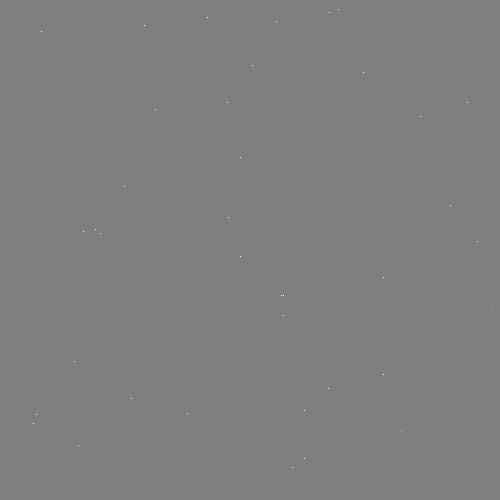

In [15]:
# Display initial layout

DisplayArray(u_init, rng=[-0.1,0.1])

# PDE Details

## Parameter Definitions

`eps` -- time resolution

`damping` -- wave damping

In [39]:
eps = tf.placeholder(tf.float32,shape=())
damping = tf.placeholder(tf.float32,shape=())

## Simulation State Variables

In [40]:
U = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

## PDE Update Rules

In [41]:
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

## Update State

In [42]:
step = tf.group(U.assign(U_), Ut.assign(Ut_))

# Run Simulation

## Initialize State

In [43]:
tf.global_variables_initializer().run()

## Simulation Steps

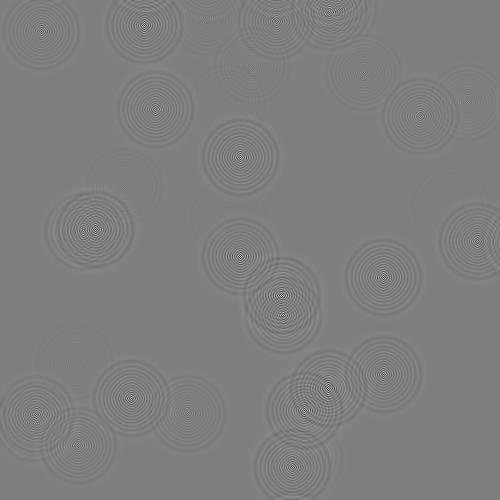

KeyboardInterrupt: 

In [44]:
for i in range(1000):
    step.run( {eps: 0.03, damping: 0.04})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])

# Sandbox

In [27]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

In [30]:
a = np.random.randn(2,2)
a

array([[-0.4061734 ,  0.07925779],
       [-0.06351864,  1.54377723]])

In [31]:
a.shape

(2, 2)

In [32]:
list(a.shape)

[2, 2]

In [33]:
list(a.shape) + [1,1]

[2, 2, 1, 1]

In [34]:
tf.constant?